Import des bibliothèques

In [1]:
# Import des bibliothèques de base
import os
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time

Chargement Des Données

In [2]:
# Chemin vers le dossier de données
data_dir = "Parlamint2018_raw"

# Chargement des textes
documents = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                text = f.read().strip()
                documents.append(text)
                labels.append(os.path.basename(root))  # Utilise le nom du dossier comme label

print(f"✅ {len(documents)} documents chargés.")
print(f"✅ {len(set(labels))} classes détectées.")

✅ 362 documents chargés.
✅ 362 classes détectées.


Aperçu Des Données

In [3]:
# Aperçu des textes chargés
print("Exemple de texte :\n")
print(documents[0][:500])  # Affiche les 500 premiers caractères du premier document

print("\nLabels détectés :")
print(set(labels))


Exemple de texte :

L’ordre du jour appelle les questions au Gouvernement.
La parole est à M. Christian Jacob, pour le groupe Les Républicains.[[Applaudissements sur les bancs du groupe LR. – M. Nicolas Dupont-Aignan applaudit aussi]]
Monsieur le Premier ministre, en vertu de l’article 20 de notre Constitution, « le Gouvernement détermine et conduit la politique de la Nation. Il dispose de l’administration et de la force armée. Il est responsable devant le Parlement ». Il vous aura pourtant fallu cinq jours pour da

Labels détectés :
{'ParlaMint-FR_2018-06-19-O1280', 'ParlaMint-FR_2018-10-30-O1041', 'ParlaMint-FR_2018-11-08-O1053', 'ParlaMint-FR_2018-10-22-O1030', 'ParlaMint-FR_2018-06-11-O1265', 'ParlaMint-FR_2018-04-04-O1176', 'ParlaMint-FR_2018-12-06-O1098', 'ParlaMint-FR_2018-06-05-O1254', 'ParlaMint-FR_2018-10-18-O1023', 'ParlaMint-FR_2018-03-21-O1163', 'ParlaMint-FR_2018-09-14-E2006', 'ParlaMint-FR_2018-05-15-O1212', 'ParlaMint-FR_2018-11-21-O1073', 'ParlaMint-FR_2018-03-27-O1168

Extraction des textes

In [4]:
import os
import pandas as pd

# Chemin vers le dossier de données
data_dir = "Parlamint2018_raw"

documents = []
labels = []

# Parcours des sous-dossiers
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".txt"):
            # Récupère le contenu du fichier
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
                documents.append(text)
                
                # Le label est le nom du sous-dossier
                label = os.path.basename(root)
                labels.append(label)

print(f"✅ Nombre total de documents : {len(documents)}")
print(f"✅ Exemples de labels : {set(labels)}")

# Création d'un DataFrame pour manipuler plus facilement les données
df_texts = pd.DataFrame({"label": labels, "text": documents})
df_texts.head()


✅ Nombre total de documents : 362
✅ Exemples de labels : {'ParlaMint-FR_2018-06-19-O1280', 'ParlaMint-FR_2018-10-30-O1041', 'ParlaMint-FR_2018-11-08-O1053', 'ParlaMint-FR_2018-10-22-O1030', 'ParlaMint-FR_2018-06-11-O1265', 'ParlaMint-FR_2018-04-04-O1176', 'ParlaMint-FR_2018-12-06-O1098', 'ParlaMint-FR_2018-06-05-O1254', 'ParlaMint-FR_2018-10-18-O1023', 'ParlaMint-FR_2018-03-21-O1163', 'ParlaMint-FR_2018-09-14-E2006', 'ParlaMint-FR_2018-05-15-O1212', 'ParlaMint-FR_2018-11-21-O1073', 'ParlaMint-FR_2018-03-27-O1168', 'ParlaMint-FR_2018-12-11-O1103', 'ParlaMint-FR_2018-06-15-O1275', 'ParlaMint-FR_2018-11-05-O1048', 'ParlaMint-FR_2018-06-15-O1274', 'ParlaMint-FR_2018-07-24-E1034', 'ParlaMint-FR_2018-10-25-O1036', 'ParlaMint-FR_2018-07-03-E1002', 'ParlaMint-FR_2018-10-04-O1007', 'ParlaMint-FR_2018-05-22-O1217', 'ParlaMint-FR_2018-11-02-O1046', 'ParlaMint-FR_2018-11-12-O1059', 'ParlaMint-FR_2018-10-03-O1005', 'ParlaMint-FR_2018-02-01-O1133', 'ParlaMint-FR_2018-12-20-O1115', 'ParlaMint-FR_2018

,label,text
0,ParlaMint-FR_2018-07-24-E1034,L’ordre du jour appelle les questions au Gouve...
1,ParlaMint-FR_2018-04-03-O1175,Le président du groupe La République en marche...
2,ParlaMint-FR_2018-07-19-E1022,L’ordre du jour appelle la suite de la discuss...
3,ParlaMint-FR_2018-11-16-O1068,L’ordre du jour appelle la suite de la discuss...
4,ParlaMint-FR_2018-11-06-O1050,L’ordre du jour appelle la suite de la discuss...


Installer & Charger SpaCy

In [5]:
import re
import spacy

# Charger le modèle SpaCy pour le français
nlp = spacy.load("fr_core_news_sm", disable=["ner", "parser"])


Nettoyage des Textes

In [6]:
def nettoyage_texte(texte):
    # Nettoyage de base (garde seulement les lettres et apostrophes)
    texte = re.sub(r"[^a-zA-ZÀ-ÿ']+", ' ', texte)
    # Lemmatisation et suppression des stopwords
    doc = nlp(texte)
    return [token.lemma_ for token in doc if not token.is_stop and len(token) > 2]

# Application du nettoyage sur les textes
df_texts["tokens"] = df_texts["text"].apply(nettoyage_texte)

print(f"✅ {len(df_texts)} documents nettoyés.")
print(f"📝 Exemple de tokens : {df_texts['tokens'].iloc[0][:20]}")


✅ 362 documents nettoyés.
📝 Exemple de tokens : ['ordre', 'jour', 'appeler', 'question', 'gouvernement', 'parole', 'Christian', 'Jacob', 'groupe', 'républicain', 'applaudissement', 'banc', 'groupe', 'Nicolas', 'Dupont', 'Aignan', 'applaudir', 'Monsieur', 'ministre', 'vertu']


Nettoyage 

In [7]:
import spacy

# Charger le modèle français de spaCy pour récupérer les stopwords
nlp = spacy.load("fr_core_news_sm")
stopwords_fr = nlp.Defaults.stop_words

# Nettoyage des textes en supprimant les stopwords
def clean_text(text):
    return " ".join([word for word in text.split() if word.lower() not in stopwords_fr])

# Appliquer le nettoyage à tes documents
df_texts["clean_text"] = df_texts["text"].apply(clean_text)

print("✅ Textes nettoyés des stopwords.")
print(df_texts["clean_text"].head())


✅ Textes nettoyés des stopwords.
0    L’ordre jour appelle questions Gouvernement. p...
1    président groupe République marche savoir prés...
2    L’ordre jour appelle suite discussion projet l...
3    L’ordre jour appelle suite discussion seconde ...
4    L’ordre jour appelle suite discussion seconde ...
Name: clean_text, dtype: object


Création des bigrammes

In [8]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Détection des bigrammes
phrases = Phrases(df_texts["tokens"], min_count=5, threshold=10)
bigram = Phraser(phrases)

# Transformation des documents avec les bigrammes
df_texts["tokens_bigrams"] = df_texts["tokens"].apply(lambda x: bigram[x])

print(f"✅ Bigrams créés. Exemple : {df_texts['tokens_bigrams'].iloc[0][:20]}")


✅ Bigrams créés. Exemple : ['ordre_jour', 'appeler', 'question', 'gouvernement', 'parole_Christian', 'Jacob', 'groupe_républicain', 'applaudissement_banc', 'groupe', 'Nicolas_Dupont', 'Aignan', 'applaudir', 'Monsieur_ministre', 'vertu_article', 'constitution', 'gouvernement', 'détermine', 'conduire', 'politique', 'nation']


Tockenisation et transformation des bigrammes en phrase

In [9]:
# Conversion des bigrammes en phrases
sentences = [bigram[s.split()] for s in df_texts["clean_text"]]

print(f"✅ Nombre total de phrases : {len(sentences)}")
print(f"📝 Exemple de phrase : {sentences[0][:20]}")



✅ Nombre total de phrases : 362
📝 Exemple de phrase : ['L’ordre', 'jour', 'appelle', 'questions', 'Gouvernement.', 'parole', 'M.', 'Christian', 'Jacob,', 'groupe', 'Républicains.[[Applaudissements', 'bancs', 'groupe', 'LR.', '–', 'M.', 'Nicolas', 'Dupont-Aignan', 'applaudit', 'aussi]]']


Entrainement du modèle

In [10]:
import multiprocessing
from gensim.models import Word2Vec

# Paramètres du modèle
w2v_model = Word2Vec(
    sentences,
    vector_size=100,  # Taille des vecteurs
    window=5,  # Contexte
    min_count=5,  # Fréquence minimale
    workers=multiprocessing.cpu_count(),  # Utilise tous les cœurs disponibles
    sg=1  # 1 pour skip-gram (meilleure précision), 0 pour CBOW (plus rapide)
)

# Entraîner le modèle
w2v_model.train(sentences, total_examples=len(sentences), epochs=10)

print("✅ Modèle Word2Vec entraîné.")


✅ Modèle Word2Vec entraîné.


vérifier la similarité

In [11]:
# Exemples de mots courants dans le corpus
exemples = ["gouvernement", "président", "ministre", "démocratie", "loi"]

for mot in exemples:
    try:
        similaires = w2v_model.wv.most_similar(positive=[mot], topn=10)
        print(f"\n🔹 Mots les plus similaires à '{mot}' :")
        for sim_mot, score in similaires:
            print(f"   {sim_mot} (similarité : {score:.2f})")
    except KeyError:
        print(f"⚠️ Le mot '{mot}' n'est pas dans le vocabulaire du modèle.")



🔹 Mots les plus similaires à 'gouvernement' :
   gouvernement, (similarité : 0.71)
   Raffarin, (similarité : 0.67)
   appartenez, (similarité : 0.67)
   souteniez, (similarité : 0.66)
   Jospin (similarité : 0.64)
   gouvernements (similarité : 0.64)
   d’alors. (similarité : 0.64)
   Emmanuel_Macron (similarité : 0.63)
   italien. (similarité : 0.62)
   Juppé (similarité : 0.62)

🔹 Mots les plus similaires à 'président' :
   Mahmoud_Abbas (similarité : 0.71)
   représentais (similarité : 0.71)
   Wolfgang (similarité : 0.69)
   Jérusalem. (similarité : 0.68)
   Mahmoud (similarité : 0.68)
   Richard, (similarité : 0.67)
   palestinienne (similarité : 0.67)
   Rugy. (similarité : 0.66)
   convoque (similarité : 0.66)
   Abbas, (similarité : 0.66)

🔹 Mots les plus similaires à 'ministre' :
   l’intérieur, (similarité : 0.73)
   ministère (similarité : 0.71)
   l’intérieur (similarité : 0.70)
   l’intérieur. (similarité : 0.70)
   Ministre (similarité : 0.69)
   auprès_ministre (simila

Calculer la similarité entre deux mots " gouvernement" et "ministre"

In [12]:
# Vérifie la similarité entre deux mots
mot1 = "gouvernement"
mot2 = "ministre"

try:
    similarite = w2v_model.wv.similarity(mot1, mot2)
    print(f"\n🔹 Similarité entre '{mot1}' et '{mot2}' : {similarite:.2f}")
except KeyError as e:
    print(f"⚠️ {e}")



🔹 Similarité entre 'gouvernement' et 'ministre' : 0.42


Clustering

Préparer les vecteurs Word2Vec Pour WARD

In [13]:
import numpy as np

# Récupérer tous les mots du modèle
words = list(w2v_model.wv.index_to_key)

# Extraire leurs vecteurs
X = np.array([w2v_model.wv[word] for word in words])

print(f"✅ {len(words)} mots extraits pour le clustering.")
print(words[:5])


✅ 63094 mots extraits pour le clustering.
['!', '–', ':', 'parole', 'M.']


Réduction de dimension( obligatoire pour WARD) 
L'algorithme de Ward nécessite des données en espace euclidien, donc il faut réduire la dimension avec PCA avant de l'utiliser.

In [14]:
from sklearn.decomposition import PCA

# Réduction de la dimension à 20 pour limiter l'utilisation de la mémoire
pca = PCA(n_components=20, random_state=42)
X_reduced = pca.fit_transform(X)

print(f"✅ Dimensions réduites à : {X_reduced.shape}")


✅ Dimensions réduites à : (63094, 20)


 Clustering avec Ward

In [15]:
from sklearn.cluster import AgglomerativeClustering

# Définir le nombre de clusters (à ajuster si nécessaire)
n_clusters = 10
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
labels = ward.fit_predict(X_reduced)

print(f"✅ Clustering terminé avec {n_clusters} clusters.")


MemoryError: Unable to allocate 14.8 GiB for an array with shape (1990394871,) and data type float64

Selectionner les mots les plus fréquebts( pour réduire le vocabulaire)

In [16]:
from collections import Counter

# Récupérer tous les mots utilisés
all_words = [word for sentence in sentences for word in sentence]

# Sélectionner les 10 000 mots les plus fréquents
most_common_words = [word for word, _ in Counter(all_words).most_common(10000)]

print(f"✅ Vocabulaire réduit à : {len(most_common_words)} mots")


✅ Vocabulaire réduit à : 10000 mots


Création de la matrice de vecteurs réduite

In [17]:
# Créer une matrice avec les vecteurs Word2Vec uniquement pour les 10 000 mots fréquents
X = np.array([w2v_model.wv[word] for word in most_common_words])

# Réduction avec PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=42)
X_reduced = pca.fit_transform(X)

print(X_reduced.shape)  # Doit être (10000, 20)


(10000, 20)


Clustering avec WARD

In [19]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 10
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
labels = ward.fit_predict(X_reduced)

print(f"✅ Clustering terminé avec {n_clusters} clusters.")


✅ Clustering terminé avec 10 clusters.


visualisation

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Réduction en 2D pour la visualisation
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=3000)
X_2d = tsne.fit_transform(X_reduced)

print(f"✅ Réduction en 2D terminée. Dimensions : {X_2d.shape}")


✅ Réduction en 2D terminée. Dimensions : (10000, 2)


Affichage des clusters

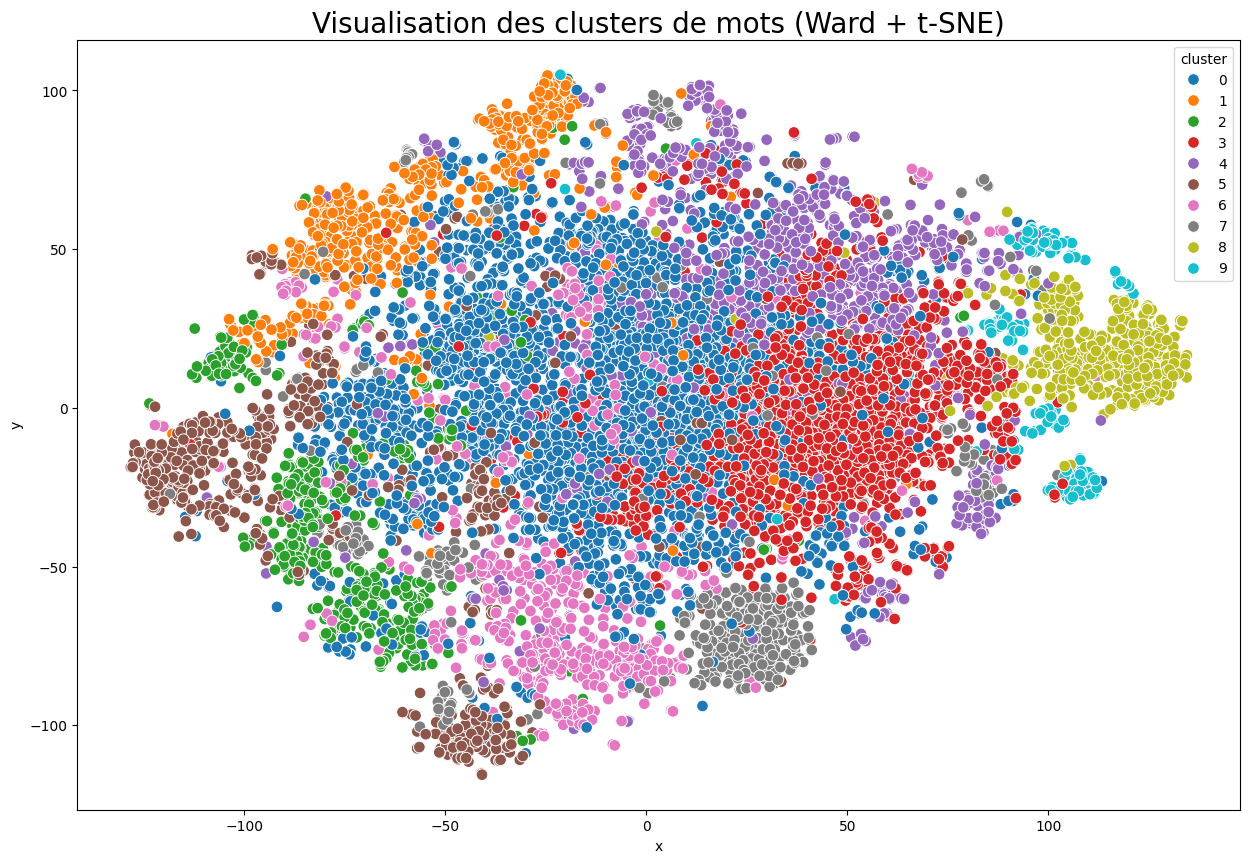

In [23]:
# Création d'un DataFrame pour faciliter l'affichage
df_clusters = pd.DataFrame({
    "word": most_common_words,
    "x": X_2d[:, 0],
    "y": X_2d[:, 1],
    "cluster": labels
})

plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_clusters, x="x", y="y", hue="cluster", palette="tab10", legend="full", s=70)
plt.title("Visualisation des clusters de mots (Ward + t-SNE)", fontsize=20)
plt.show()


Affichage des mots par clusters

In [24]:
for cluster_id in range(n_clusters):
    words_in_cluster = df_clusters[df_clusters["cluster"] == cluster_id]["word"].values[:10]
    print(f"🔹 Cluster {cluster_id + 1} : {', '.join(words_in_cluster)}")


🔹 Cluster 1 : non, droit, s’agit, cas, cadre, nombre, vise, situation, mesure, mesures
🔹 Cluster 2 : %, millions, 000, entreprises, d’euros, milliards, budget, crédits, euros, salariés
🔹 Cluster 3 : territoires, formation, territoire, logements, communes, enfants, jeunes, établissements, logement, zones
🔹 Cluster 4 : !, :, ?, C’est, bien, c’est, qu’il, n’est, Gouvernement, faire
🔹 Cluster 5 : –, été, d’une, d’un, «, ;, loi, », texte, –,
🔹 Cluster 6 : France, pays, européenne, produits, développement, France,, l’Union, français, prix, coût
🔹 Cluster 7 : personnes, conditions, protection, affaires, justice, contrôle, procédure, femmes, lutte_contre, données
🔹 Cluster 8 : »., l’Assemblée, loi., débats, nationale., pas., l’économie, France., Gouvernement., pays.
🔹 Cluster 9 : parole, M., n°, l’amendement, Mme, soutenir, commission, l’avis, amendement, amendements
🔹 Cluster 10 : groupe, bancs, l’article, groupes, LaREM]], LR]], séance, MODEM]], FI]], LaREM


Le dindogramme des clusters

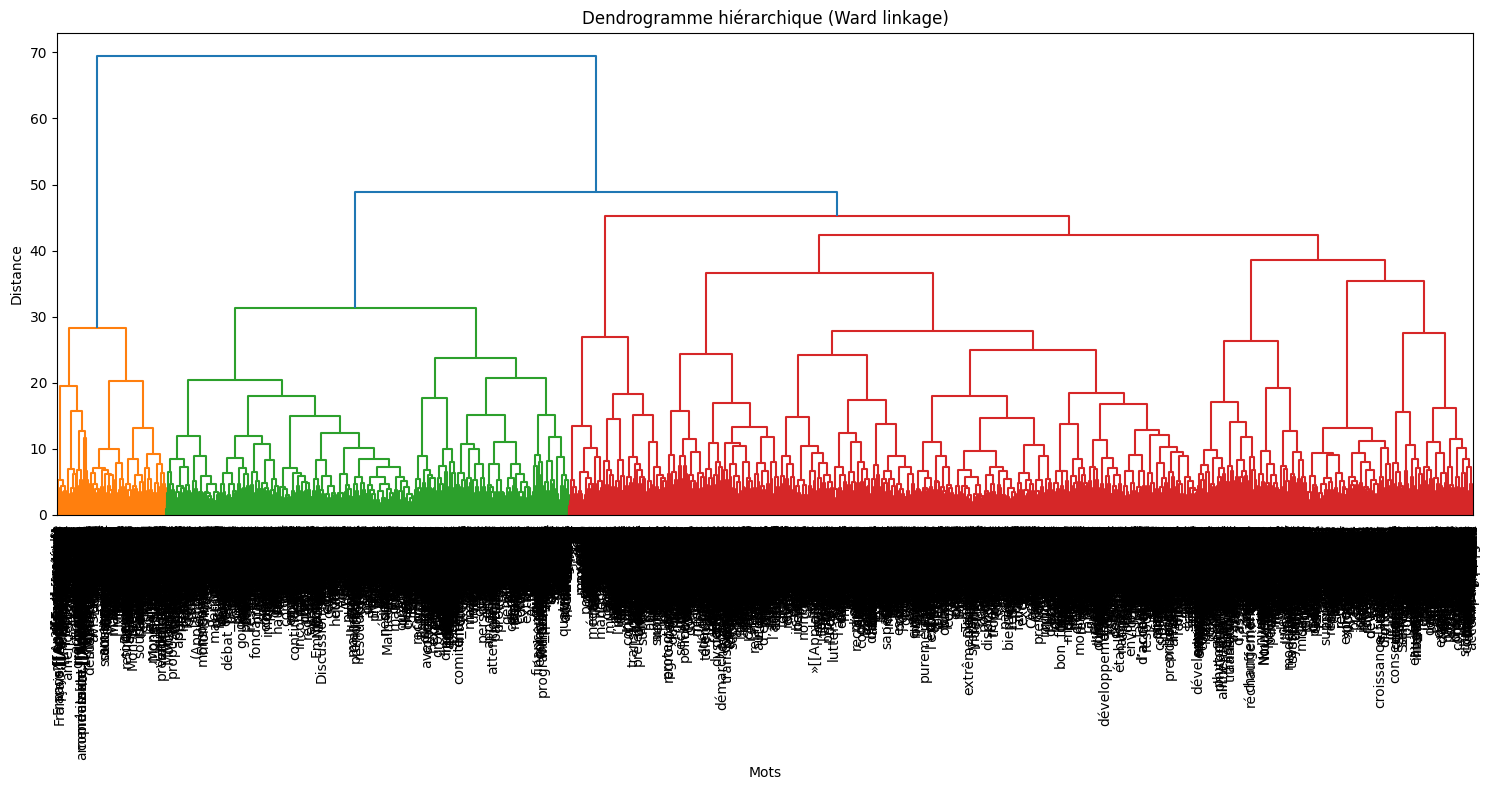

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Création du linkage avec Ward
Z = linkage(X_reduced, method="ward")

# Affichage du dendrogramme
plt.figure(figsize=(15, 8))
plt.title("Dendrogramme hiérarchique (Ward linkage)")
plt.xlabel("Mots")
plt.ylabel("Distance")
dendrogram(Z, labels=most_common_words, leaf_rotation=90, leaf_font_size=10)
plt.tight_layout()
plt.show()


la méthode des marches d'inertie

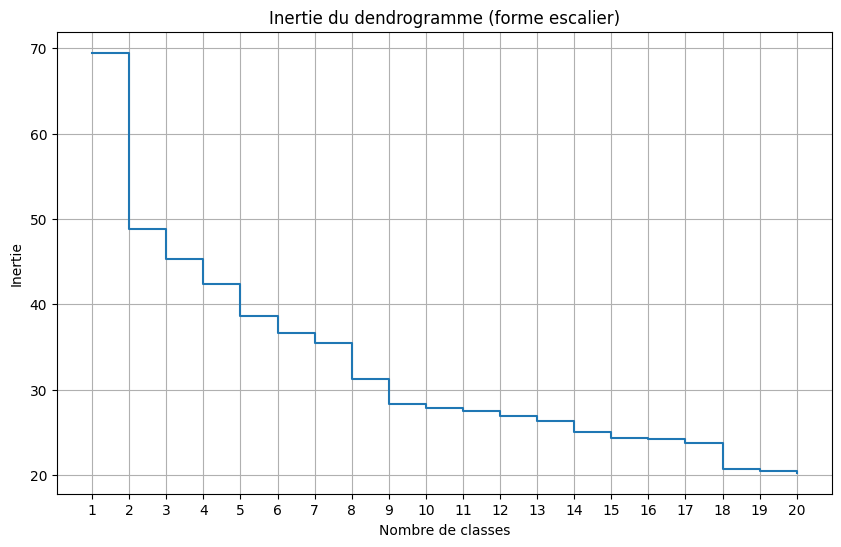

In [33]:
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import numpy as np

# Clustering hiérarchique avec Ward
Z = linkage(X_reduced, method="ward")

# Récupération des distances de fusion (inerties)
inertie = Z[:, 2]
inertie_sorted = np.sort(inertie)[::-1]

# Plot en escalier
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), inertie_sorted[:20], drawstyle="steps-post")
plt.xticks(range(1, 21))# Axe X avec pas de 1
plt.xlabel("Nombre de classes")
plt.ylabel("Inertie")
plt.title("Inertie du dendrogramme (forme escalier)")
plt.grid(True)
plt.show()


Appliquer KMeans avec le nombre optimal k=5

In [34]:
from sklearn.cluster import KMeans

# Nombre optimal de clusters (déterminé par la méthode du coude)
k_optimal = 3

# Clustering sur les vecteurs des mots fréquents
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
labels = kmeans.fit_predict(X_reduced)

# Ajouter les labels à un DataFrame
df_clusters = pd.DataFrame({
    "word": most_common_words,
    "cluster": labels
})
df_clusters.head()


,word,cluster
0,!,2
1,–,0
2,:,2
3,parole,1
4,M.,1


Afficher les mots représentatifs de chaque cluster

In [36]:
for i in range(k_optimal):
    print(f"\n🔹 Cluster {i} :")
    print(df_clusters[df_clusters["cluster"] == i]["word"].head(10).tolist())



🔹 Cluster 0 :
['–', '%', 'personnes', 'millions', 'cadre', 'nombre', '000', '–,', 'vise', 'l’ensemble']

🔹 Cluster 1 :
['parole', 'M.', 'n°', 'groupe', 'l’amendement', 'Mme', 'soutenir', 'commission', 'l’avis', 'amendement']

🔹 Cluster 2 :
['!', ':', '?', 'été', 'bancs', 'd’une', 'C’est', 'bien', 'd’un', 'c’est']


Visualisation

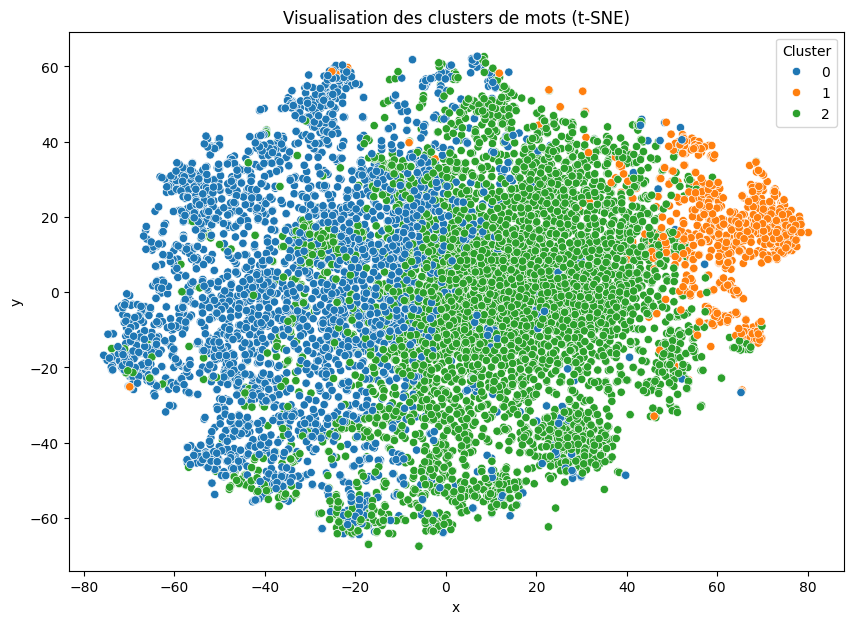

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_2d = tsne.fit_transform(X_reduced)

df_clusters["x"] = X_2d[:, 0]
df_clusters["y"] = X_2d[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_clusters, x="x", y="y", hue="cluster", palette="tab10")
plt.title("Visualisation des clusters de mots (t-SNE)")
plt.legend(title="Cluster")
plt.show()


Extraire le mot représentant de chaque cluster

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

representants = []

for i in range(k_optimal):
    # Récupération des mots du cluster i
    mots_cluster = df_clusters[df_clusters["cluster"] == i]["word"].tolist()
    vecteurs = np.array([w2v_model.wv[word] for word in mots_cluster])

    # Calcul du centroïde
    centroide = vecteurs.mean(axis=0)

    # Calcul de la similarité cosinus avec le centroïde
    similarites = cosine_similarity([centroide], vecteurs)[0]
    mot_representant = mots_cluster[np.argmax(similarites)]

    representants.append({
        "Cluster": i,
        "Représentant": mot_representant,
        "Nombre de mots": len(mots_cluster)
    })

# Affichage
df_representants = pd.DataFrame(representants)
print("✅ Mots représentants par cluster :")
display(df_representants)


✅ Mots représentants par cluster :


,Cluster,Représentant,Nombre de mots
0,0,décote,3861
1,1,Rédactionnel.,868
2,2,Discussion_proposition,5271


Extraire paragon de chaque cluster

In [40]:
parangons = []

# Calcul des centroïdes de tous les clusters à l'avance
centroides = {
    i: np.mean([w2v_model.wv[word] for word in df_clusters[df_clusters["cluster"] == i]["word"]], axis=0)
    for i in range(k_optimal)
}

for i in range(k_optimal):
    mots_cluster = df_clusters[df_clusters["cluster"] == i]["word"].tolist()
    vecteurs_cluster = np.array([w2v_model.wv[word] for word in mots_cluster])

    # Moyenne des centroïdes des autres clusters
    autres_centroides = [centroides[j] for j in range(k_optimal) if j != i]
    moyenne_autres = np.mean(autres_centroides, axis=0)

    # Calcul des distances cosinus à la moyenne des autres centroïdes
    distances = cosine_similarity(vecteurs_cluster, [moyenne_autres])
    mot_parangon = mots_cluster[np.argmin(distances)]

    parangons.append({
        "Cluster": i,
        "Parangon": mot_parangon,
        "Nombre de mots": len(mots_cluster)
    })

# Affichage
df_parangons = pd.DataFrame(parangons)
print("🌟 Mots parangons par cluster :")
display(df_parangons)


🌟 Mots parangons par cluster :


,Cluster,Parangon,Nombre de mots
0,0,sites,3861
1,1,exposer,868
2,2,l’extérieur,5271
